In [2]:
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.metrics import accuracy_score 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import numpy.random as r 
import matplotlib.pyplot as plt 
import cv2

import glob
import matplotlib.gridspec as gridspec #A grid layout to place subplots within a figure.
import tensorflow as tf 

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

%matplotlib inline 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sn #for visualization

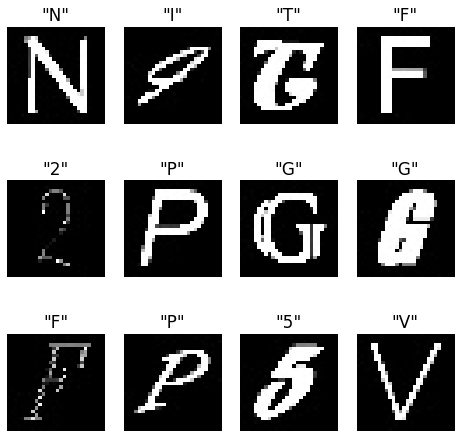

In [3]:
characters = glob.glob("dataset_characters/**/*.jpg")
cols=4
rows=3
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(characters),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(characters[rand[i]])
    label = characters[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [29]:
X=[]
labels =[]

for image_path in characters:
    image = cv2.imread(image_path, 0) #0 = grayscale
    image = cv2.resize(image, (28, 28)) 
    X.append(image)
    label = image_path.split(os.path.sep)[-2]
    labels.append(label)

    
print(image.shape)
print(image.size)
 
X = np.array(X, dtype = "float")
print(X[10000])
print(labels[10000])
print(len(labels))
print(X.shape)

(28, 28)
784
[[  2.   0.   0.   1.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   3.   0.   0.   2.   1.   0.   2.   0.   0.   0.   0.]
 [  0.   5.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   3.   0.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   3.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
    0.   0.   1.   0.   2.   3.   0.   1.   4.   0.   0.   0.   0.   0.]
 [  2.   0.   0.   0.   0.   5.   0. 254. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 252. 252. 255. 253.   0.   0.   0.   0.   0.   0.]
 [  1.   1.   1.   1.   2.   0.   0. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 254. 255. 255. 255. 253. 255.   2.   3.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   4. 254. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 252. 253. 255.   0.   0.   0.   0.   0.   0.]
 [  1.   2.   2.   0.   0.   2.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   1. 255. 255. 255.  41.   0

In [22]:
#print(X[0])
y = np.array(labels)
#y = y.reshape(y.shape[0],1)
print(y.shape)

(37623,)


In [30]:
X = X.reshape(X.shape[0], 784)
print(X)

X_scale = StandardScaler()
X = X_scale.fit_transform(X)

X[0,:] # Looking the new features after scaling
X.shape 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


(37623, 784)

In [31]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22573, 784)
(15050, 784)
(22573,)
(15050,)


In [63]:
def f(z):
    return 1 / (1 + np.exp(-z))
    #return np.maximum(0,z) #ReLU
    #return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)) #tanh


def f_deriv(z):
    return f(z) * (1 - f(z))
    #return np.greater(z, 0).astype(int) #ReLU
    #return 1-(np.square(f(z))) #tanh

In [64]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [65]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [66]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [67]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [68]:
def train_nn(nn_structure, X, y, iter_num=5000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            #W[l] += -alpha * (1.0/N * tri_W[l])
            W[l] += -alpha * (1.0/N * tri_W[l] + 0.001 * W[l]) #regularization
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [69]:
nn_structure = [64, 40, 10]

# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, 3000)


Starting gradient descent for 3000 iterations
Iteration 0 of 3000


ValueError: shapes (40,64) and (784,) not aligned: 64 (dim 1) != 784 (dim 0)